https://towardsdatascience.com/sparse-autoencoder-neural-networks-how-to-utilise-sparsity-for-robust-information-encoding-6aa9ff542bc9

In [11]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense # for adding Dense layers to AE model
from keras.models import Model # for creating a Neural Network Autoencoder model

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Visualization
import matplotlib
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
import seaborn as sns # for plotting neuron heatmap
print('seaborn: %s' % sns.__version__) # print version

# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir = os.path.dirname(sys.path[0])

Tensorflow/Keras: 2.11.0
numpy: 1.23.4
matplotlib: 3.7.1
seaborn: 0.12.2


x_train Shape: (60000, 28, 28)
y_train Shape: (60000,)
x_test Shape: (10000, 28, 28)
y_test Shape: (10000,)


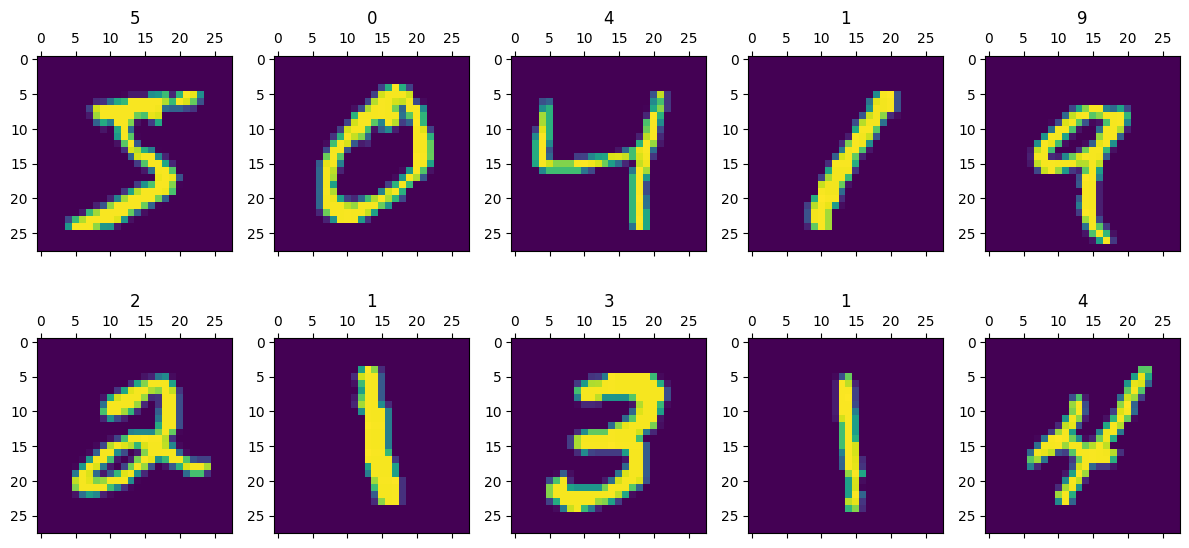

In [12]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Print shapes
print("x_train Shape:", x_train.shape)
print("y_train Shape:", y_train.shape)
print("x_test Shape:", x_test.shape)
print("y_test Shape:", y_test.shape)

# Display images of the first 10 digits in the training set and their true labels
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n = 0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(x_train[n])
        axs[i,j].set(title=y_train[n])
        n += 1
plt.show()

In [13]:
# Reshape and normalize (divide by 255) input data
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

# Print shapes
print("x_train Shape:", x_train.shape)
print("x_test Shape:", x_test.shape)

x_train Shape: (60000, 784)
x_test Shape: (10000, 784)


Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE-Input-Layer (InputLayer)  [(None, 784)]            0         
                                                                 
 AE-Encoder-Hidden-Layer (De  (None, 16)               12560     
 nse)                                                            
                                                                 
 AE-Bottleneck-Layer (Dense)  (None, 16)               272       
                                                                 
 AE-Decoder-Hidden-Layer (De  (None, 16)               272       
 nse)                                                            
                                                                 
 AE-Output-Layer (Dense)     (None, 784)               13328     
                                                                 
Total params: 26,432
Trainable params: 26,432
Non

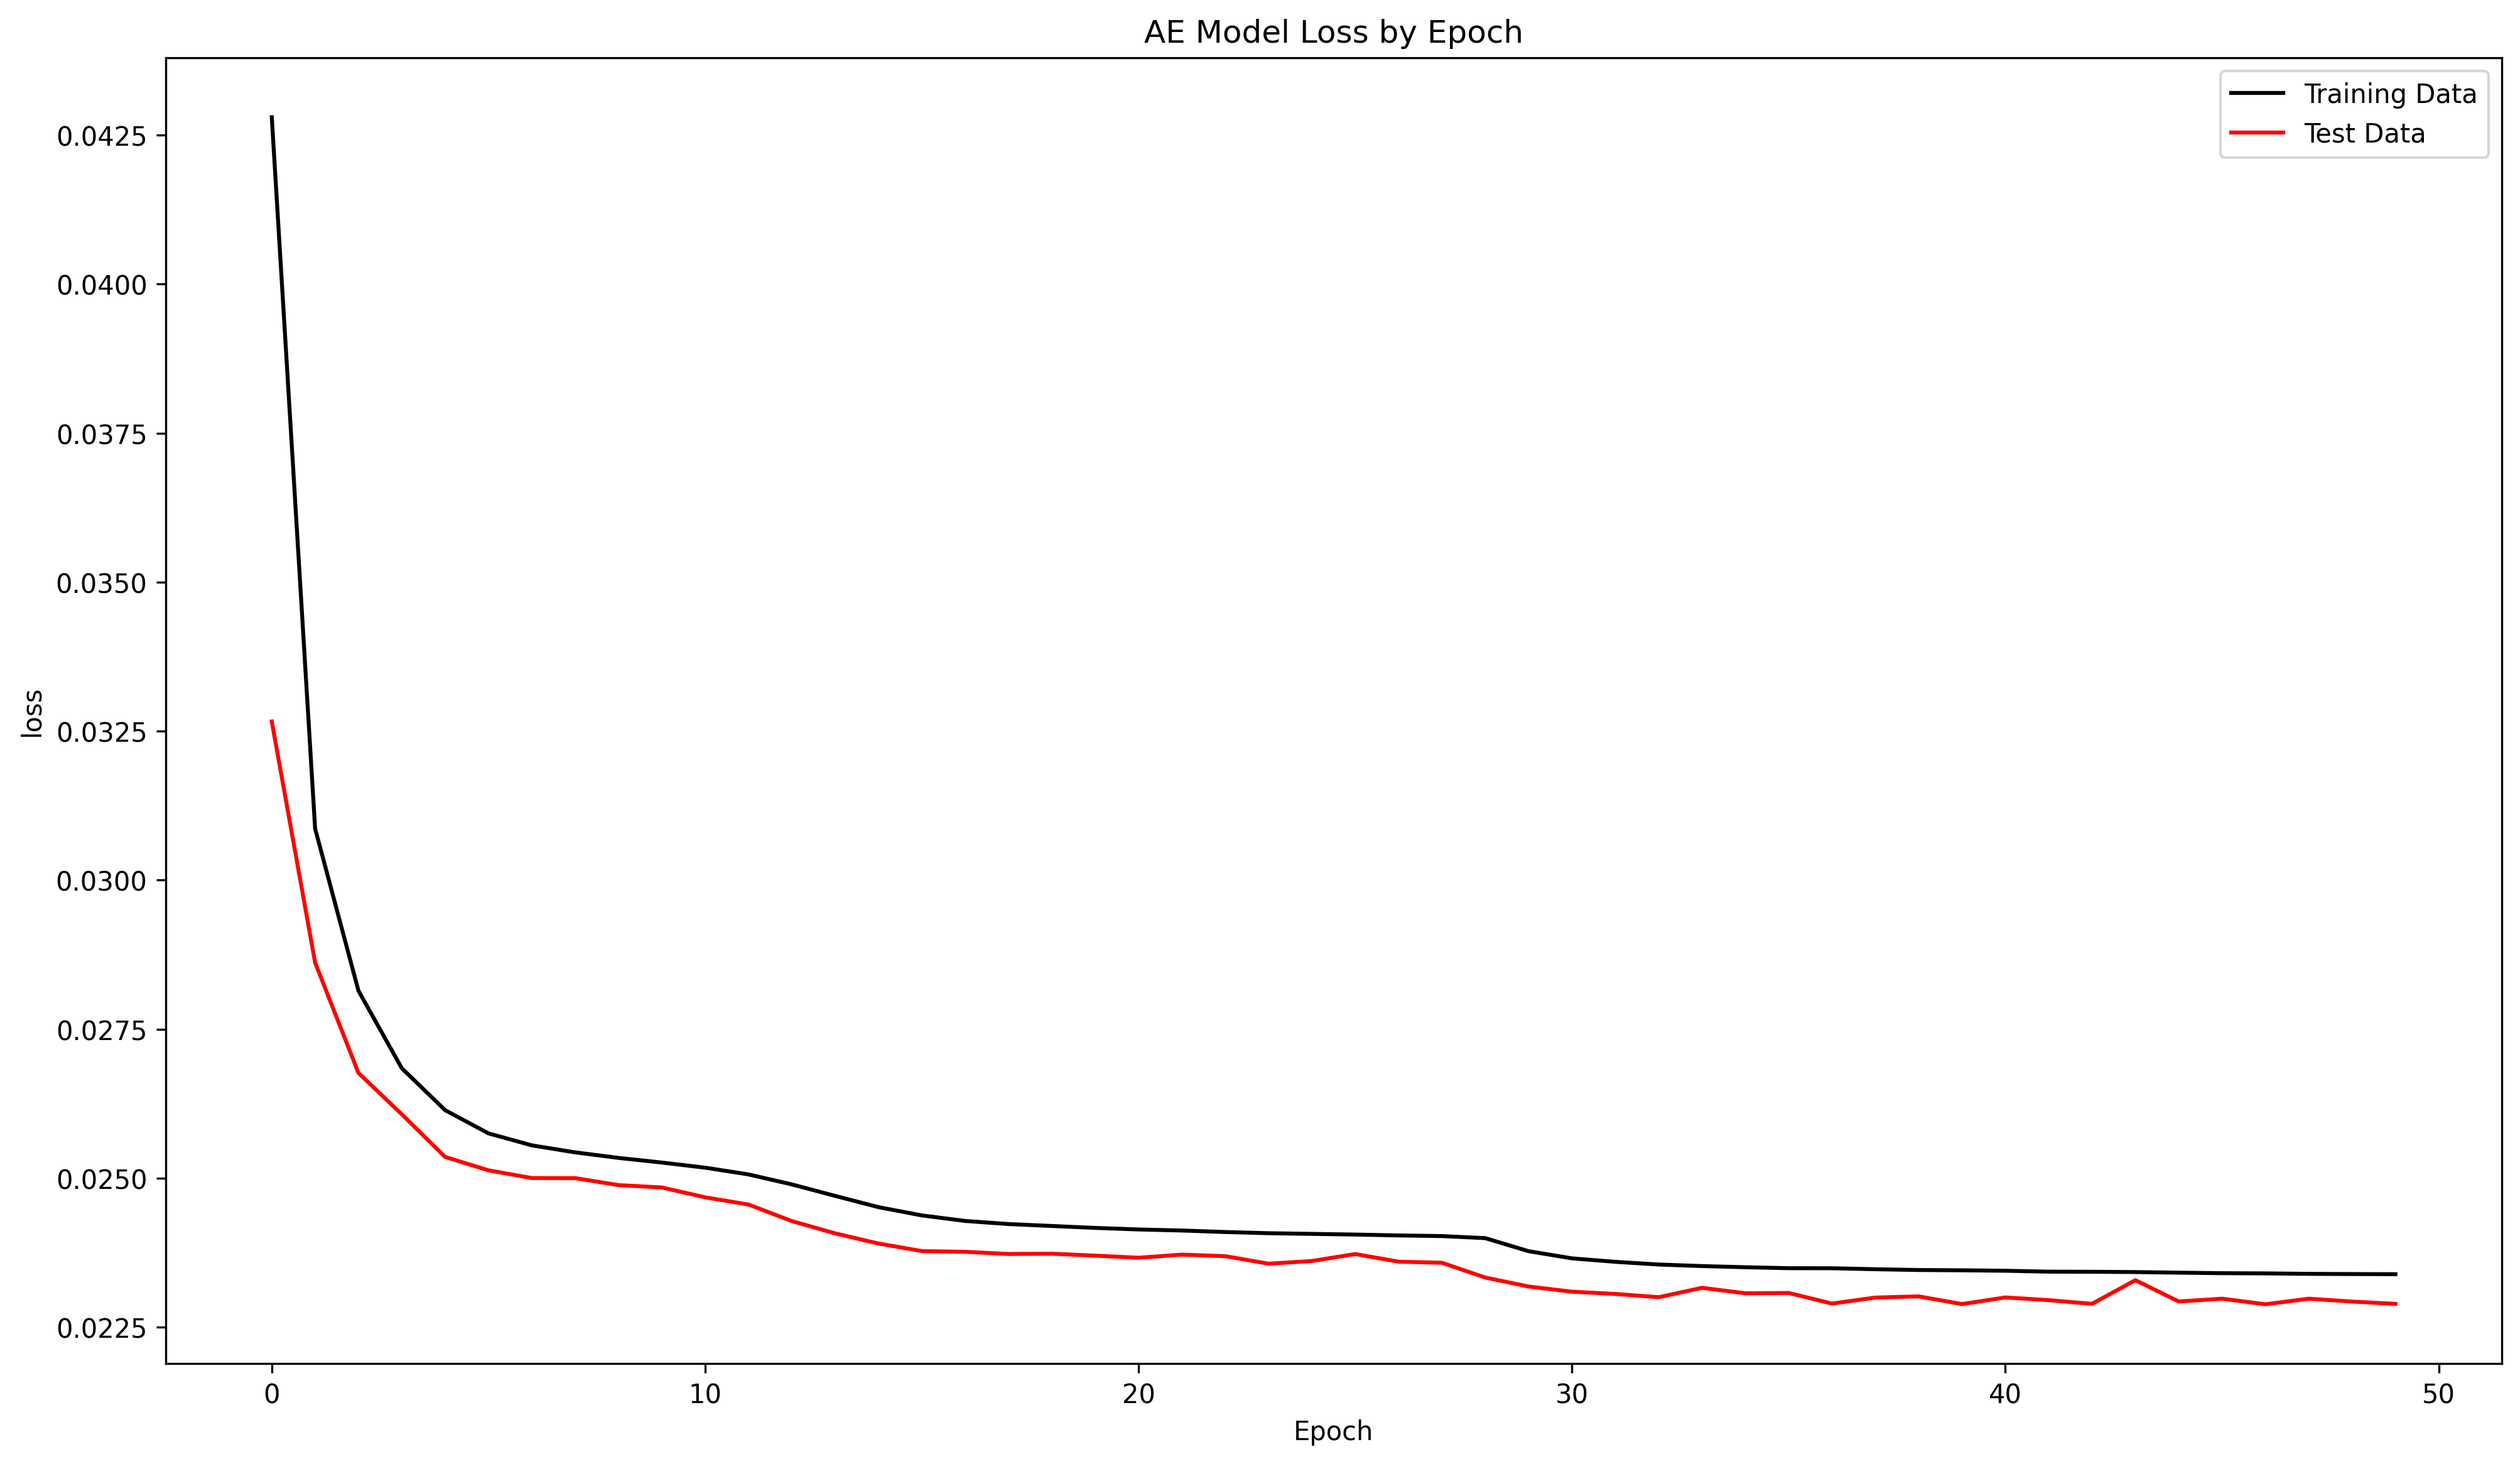

In [14]:
#---------- Build AE Model ----------#

# Shapes
AE_n_inputs = x_train.shape[1] # No. of neurons for the input and output layers
AE_n_hidden = 16 # No. of neurons for hte hidden layers (including bottleneck)

# Layers
AE_visible = Input(shape=(AE_n_inputs,), name='AE-Input-Layer') # Input-Layer
AE_enc_hidden = Dense(units=AE_n_hidden, activation='relu', name='AE-Encoder-Hidden-Layer')(AE_visible) # Encoder-Hidden-Layer
AE_bottleneck = Dense(units=AE_n_hidden, activation='relu', name='AE-Bottleneck-Layer')(AE_enc_hidden) # Bottleneck-Layer
AE_dec_hidden = Dense(units=AE_n_hidden, activation='relu', name='AE-Decoder-Hidden-Layer')(AE_bottleneck) # Decoder-Hidden-Layer
AE_output = Dense(units=AE_n_inputs, activation='sigmoid', name='AE-Output-Layer')(AE_dec_hidden)

# Define autoencoder model
AE_model = Model(inputs=AE_visible, outputs=AE_output, name='Autoencoder-Model')

# Compile autoencoder model
AE_model.compile(optimizer='adam', loss='mse')

# Print model summary
print(AE_model.summary())

# Fit the autoencoder model to reconstruct input
AE_history = AE_model.fit(x_train, x_train, epochs=50, batch_size=16, verbose=1, validation_data=(x_test, x_test))

#---------- Plot a loss chart ----------#

fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='AE Model Loss by Epoch', loc='center')
ax.plot(AE_history.history['loss'], label='Training Data', color='black')
ax.plot(AE_history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='loss')
plt.legend()
plt.show()

#---------- Save AE Encoder Model ----------#

# Define an encoder model without the decoder
AE_encoder = Model(inputs=AE_visible, outputs=AE_bottleneck)

# Compile encoder model
AE_encoder.compile(optimizer='adam', loss='mse')

# Save the encoder model to file
AE_encoder.save(main_dir+'/data/AE_encoder.h5')

Model: "Sparse-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SAE-Input-Layer (InputLayer  [(None, 784)]            0         
 )                                                               
                                                                 
 SAE-Encoder-Hidden-Layer (D  (None, 16)               12560     
 ense)                                                           
                                                                 
 SAE-Bottleneck-Layer (Dense  (None, 16)               272       
 )                                                               
                                                                 
 SAE-Decoder-Hidden-Layer (D  (None, 16)               272       
 ense)                                                           
                                                                 
 SAE-Output-Layer (Dense)    (None, 784)  

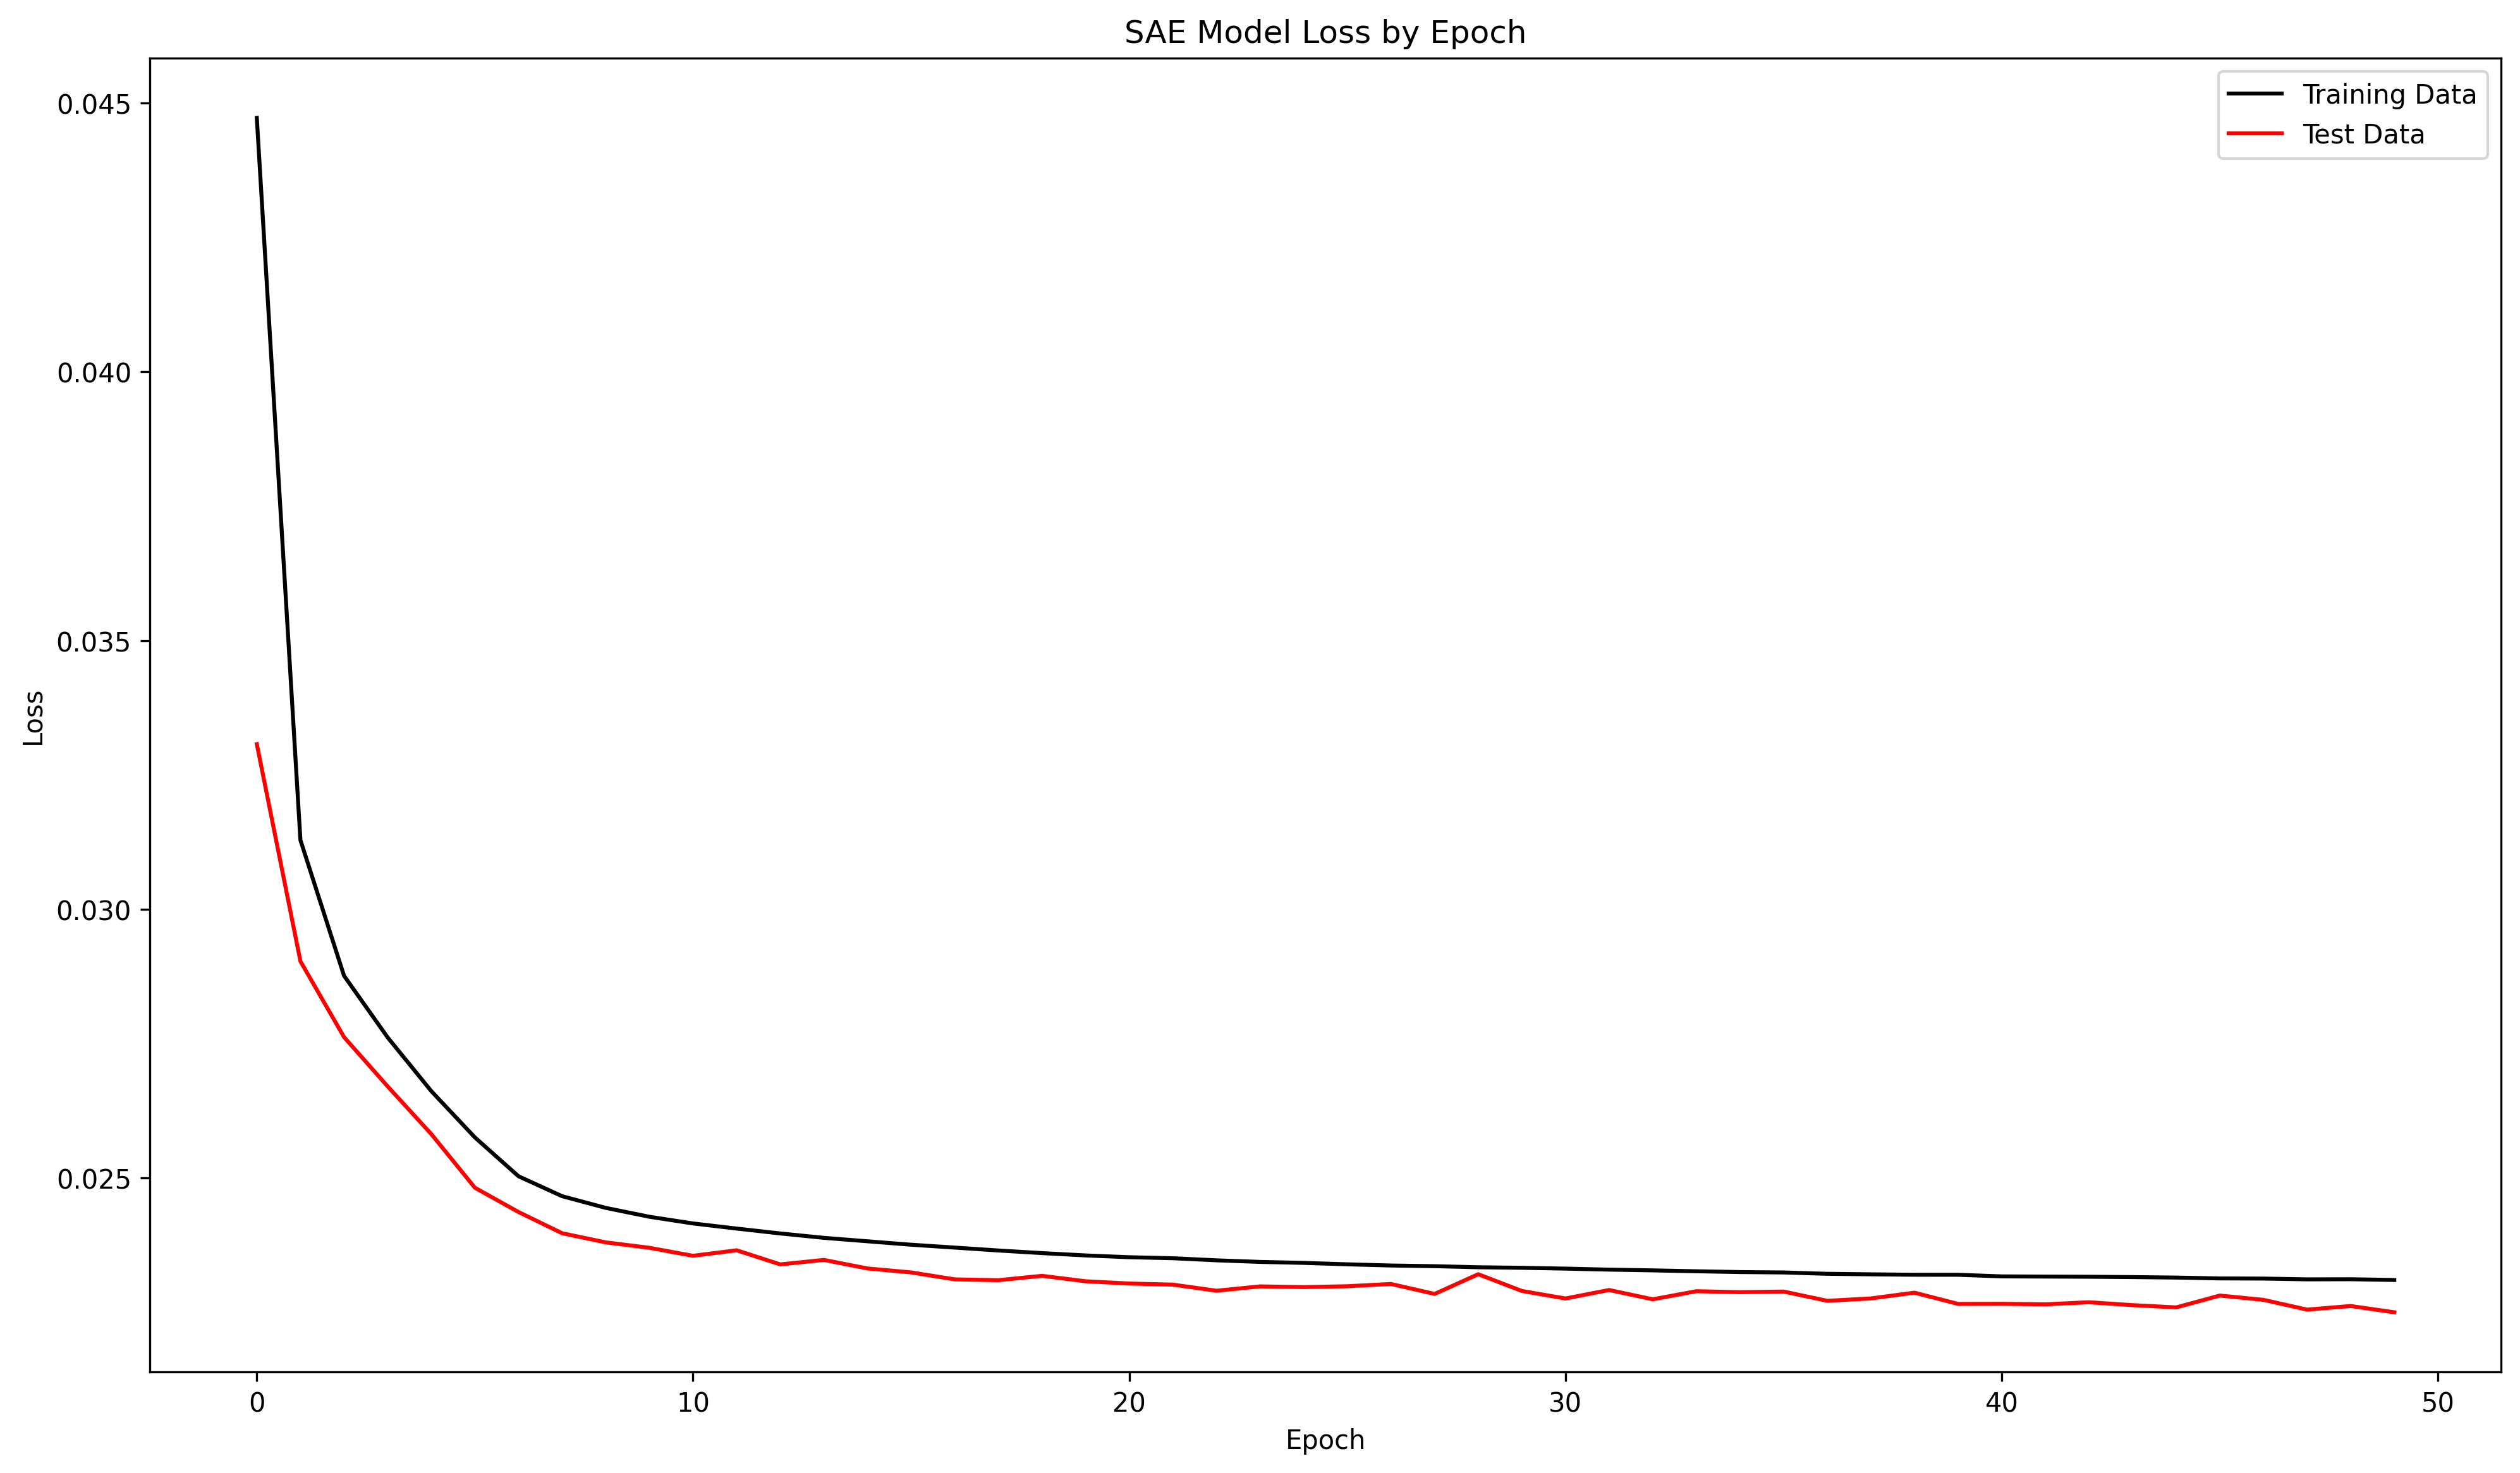

In [15]:
#---------- Build SAE Model ----------#

# Shapes
SAE_n_inputs = x_train.shape[1] # No. of neurons for the input and output layer
SAE_n_hidden = 16 # No. of neurons for the hidden layers (including bottleneck)

# Layers

SAE_visible = Input(shape=(SAE_n_inputs,), name='SAE-Input-Layer') # Input-Layer
SAE_enc_hidden = Dense(units=SAE_n_hidden, activation='relu', name='SAE-Encoder-Hidden-Layer')(SAE_visible) # Encoder-Hidden-Layer
SAE_bottleneck = Dense(units=SAE_n_hidden, activation='relu', activity_regularizer=keras.regularizers.L1(0.0001), name='SAE-Bottleneck-Layer')(SAE_enc_hidden) # Bottleneck-Layer
SAE_dec_hidden = Dense(units=SAE_n_hidden, activation='relu', name='SAE-Decoder-Hidden-Layer')(SAE_bottleneck) # Decoder-Hidden-Layer
SAE_output = Dense(units=SAE_n_inputs, activation='sigmoid', name='SAE-Output-Layer')(SAE_dec_hidden) # Output-Layer

# Define Sparse autoencoder model
SAE_model = Model(inputs=SAE_visible, outputs=SAE_output, name='Sparse-Autoencoder-Model')

# Compile Sparse autoencoder model
SAE_model.compile(optimizer='adam', loss='mse')

# Print model summary
print(SAE_model.summary())

# Fit the Sparse autoencoder model to reconstruct input
SAE_history = SAE_model.fit(x_train, x_train, epochs=50, batch_size=16, verbose=1, validation_data=(x_test, x_test))

#---------- Plot a loss chart ----------#

fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(SAE_history.history['loss'], label='Training Data', color='black')
ax.plot(SAE_history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()

#---------- Save SAE Encoder Model ----------#

# Define an encoder model without the decoder 
SAE_encoder = Model(inputs=SAE_visible, outputs=SAE_bottleneck)

# Compile encoder model
SAE_encoder.compile(optimizer='adam', loss='mse')

# Save the encoder model to file
SAE_encoder.save(main_dir+'/data/SAE_encoder.h5')

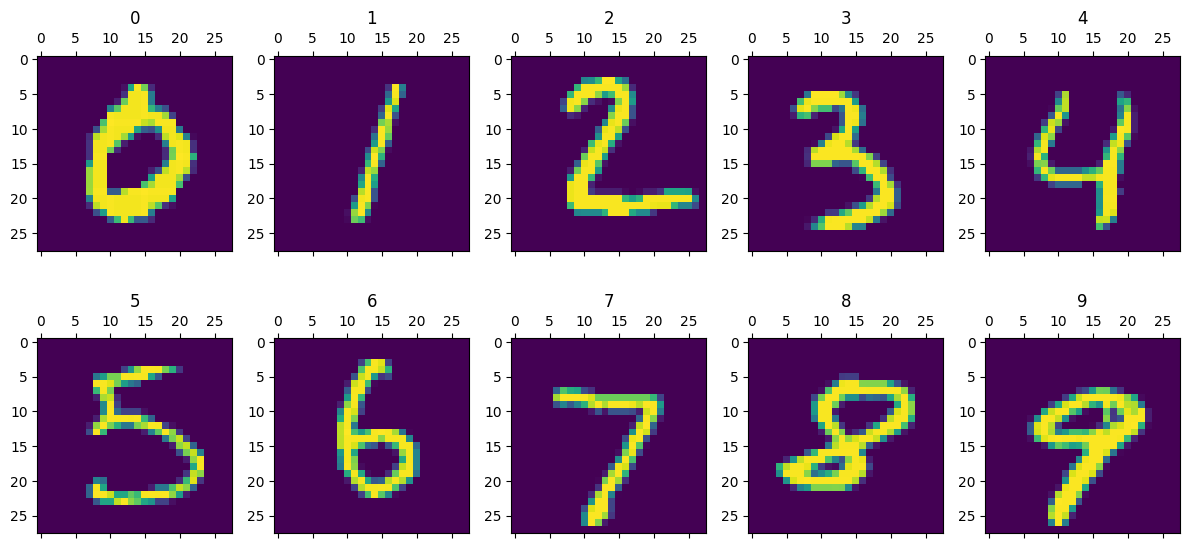

In [16]:
# Reshape back
x_test_back = x_test.reshape(10000, 28, 28)

# Display select images of digits in the testing set and their true labels
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
imglist = [3,2,1,32,4,15,21,0,61,9]
n = 0
for i in range(0,2):
    for j in range(0,5):
        k = imglist[n]
        axs[i,j].matshow(x_test_back[k])
        axs[i,j].set(title=y_test[k])
        n += 1
plt.show()

1/1 [==============================] - 0s 21ms/step


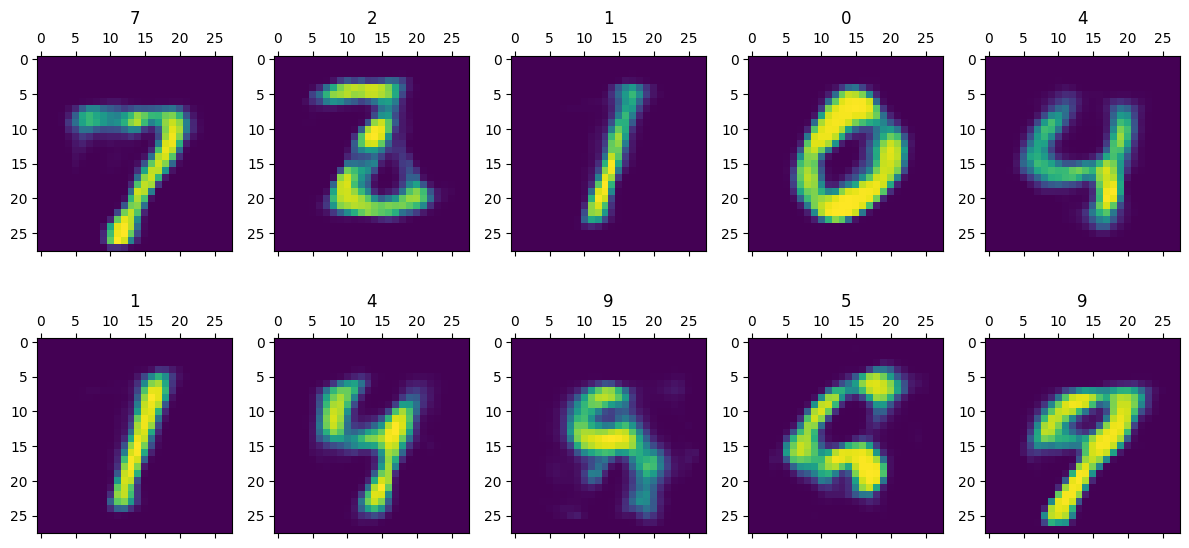

In [17]:
# Process images with Autoencoder
for i in range(0, 10):
    img=AE_model.predict(x_test[i].reshape(1,784))
    if i==0: 
        processed_imgs=np.copy(img) 
    else:
        processed_imgs=np.concatenate((processed_imgs, img))
processed_imgs=processed_imgs.reshape(10, 28, 28)

# Display processed images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(processed_imgs[n])
        axs[i,j].set(title=y_test[n])
        n=n+1
plt.show() 

1/1 [==============================] - 0s 22ms/step


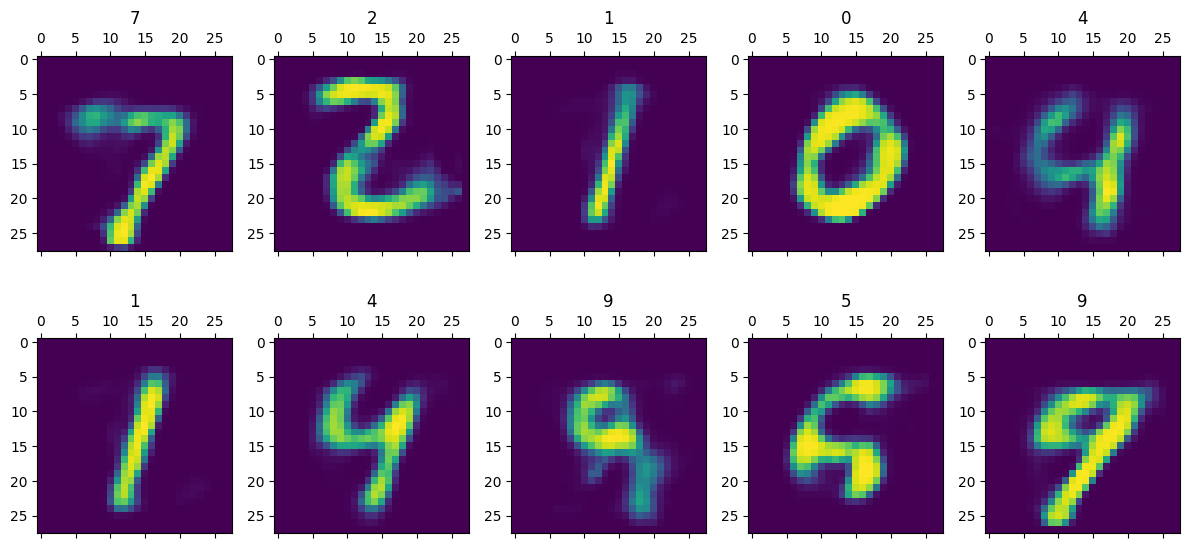

In [18]:
# Process images with Sparse-Autoencoder
for i in range(0, 10):
    img=SAE_model.predict(x_test[i].reshape(1,784))
    if i==0: 
        processed_imgs=np.copy(img) 
    else:
        processed_imgs=np.concatenate((processed_imgs, img))
processed_imgs=processed_imgs.reshape(10, 28, 28)

# Display processed images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(processed_imgs[n])
        axs[i,j].set(title=y_test[n])
        n=n+1
plt.show() 

In [19]:
imglist = [3,2,1,32,4,15,21,0,61,9]

# Encode iamges with AE encoder
for i in imglist:
    enc = AE_encoder.predict(x_test[i].reshape(1,784))
    if i==imglist[0]:
        AE_encoded_imgs=np.copy(enc)
    else:
        AE_encoded_imgs=np.concatenate((AE_encoded_imgs, enc))

# Encode images with SAE encoder
for i in imglist:
    enc = SAE_encoder.predict(x_test[i].reshape(1,784))
    if i==imglist[0]:
        SAE_encoded_imgs=np.copy(enc)
    else:
        SAE_encoded_imgs=np.concatenate((SAE_encoded_imgs, enc))

1/1 [==============================] - 0s 18ms/step


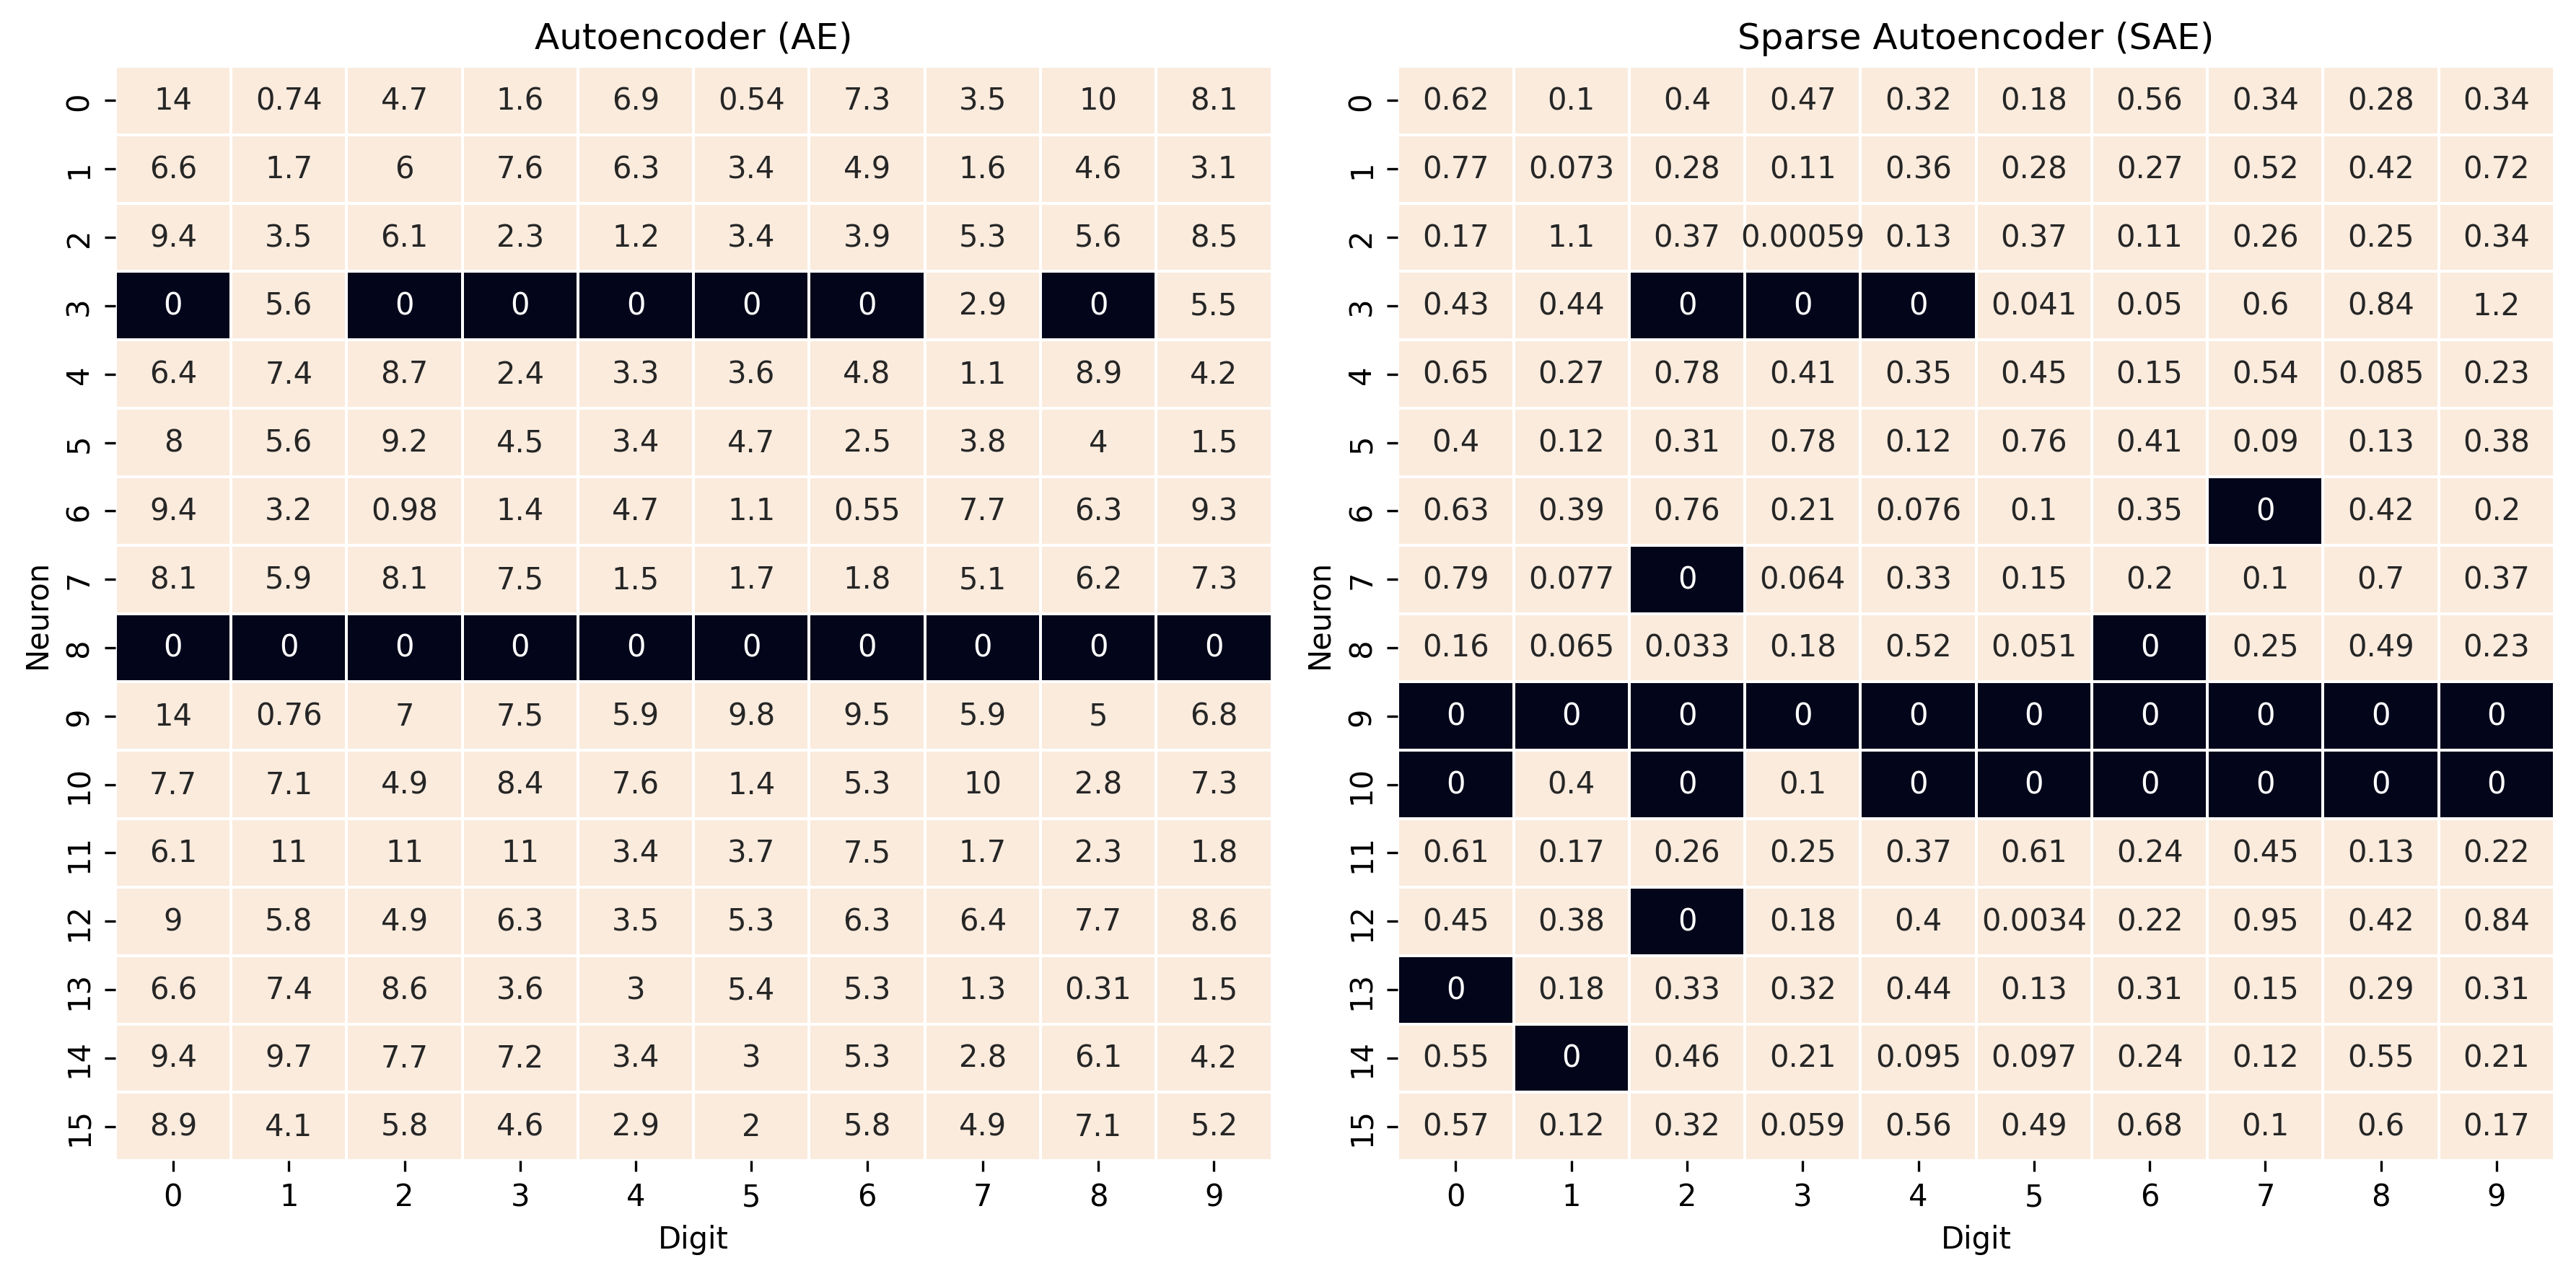

In [20]:
# Plot SNS heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(12,6), dpi=300)
sns.heatmap(AE_encoded_imgs.transpose(), linewidth=0.5, annot=True, vmin=0, vmax=0.01, cbar=False, ax=ax1)
sns.heatmap(SAE_encoded_imgs.transpose(), linewidth=0.5, annot=True, vmin=0, vmax=0.00001, cbar=False, ax=ax2)
ax1.set(title='Autoencoder (AE)', xlabel='Digit', ylabel='Neuron')
ax2.set(title='Sparse Autoencoder (SAE)', xlabel='Digit', ylabel='Neuron')
plt.show()